# Clustering Raw Data

In this notebook, we will be clustering the raw data using different clustering algorithms. We will first apply TFIDF, and optionally topic modelling. We will be using the following clustering algorithms:
    - KMeans
    - DBSCAN
    - Agglomerative Clustering

We will also be using t-SNE to reduce the dimensionality of the data before clustering.


### Cell 1 - Importing Libraries

In [1]:
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch
from tqdm import tqdm_notebook as tqdm

### Cell 2 - Clustering Class

This class is the main class for clustering the data. It takes in the data as a pandas dataframe, and the number of clusters and the number of dimensions for the t-SNE algorithm. It also takes in the number of topics for the topic modelling algorithms. It has the following methods:
    - apply_tfidf: Applies TFIDF to the data
    - topic_modelling: Applies topic modelling to the data
    - apply_tsne: Applies t-SNE to the data
    - generate_clusters: Generates clusters using the clustering algorithm specified
    - plot_clusters: Plots the clusters
    - calculate_silhouette: Calculates the silhouette score for the cluster range provided and outputs the best number of clusters

This class is stored in `src/data/algorithms.py` and can be used by calling `from src.data.algorithms import Clustering`

In [2]:
class Clustering:

    def __init__(self,
                 data,
                 n_topics=10,
                 n_clusters=10,
                 cluster_dimensions=2):

        self.data = data
        self.n_clusters = n_clusters
        self.cluster_dimensions = cluster_dimensions
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            ngram_range=(1, 2),
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=False
        )

        # # # # Topic Modelling Algos # # # #

        self.LDA = LatentDirichletAllocation(
            n_components=n_topics,
            learning_method='online',
            learning_offset=50,
            random_state=0
        )
        self.NMF = NMF(
            n_components=n_topics,
            init='nndsvd',
            random_state=0,
            max_iter=500
        )
        self.LSA = TruncatedSVD(
            n_components=n_topics,
            algorithm='arpack',
            random_state=0
        )

        self.TSNE = TSNE(
            n_components=self.cluster_dimensions,
            perplexity=50,
            learning_rate=200,
            random_state=0
        )

        # # # # Clustering Algos # # # #

        self.KM = KMeans(
            n_clusters=self.n_clusters,
            random_state=0
        )

        self.DBSCAN = DBSCAN(
            eps=0.5,
            min_samples=5
        )

        self.HC = AgglomerativeClustering(
            n_clusters=self.n_clusters,
            linkage='ward'
        )
        self.clustering_algo = {'KM': self.KM,
                                'DBSCAN': self.DBSCAN,
                                'HC': self.HC}


    def apply_tfidf(self):
        self.about_us = self.data['cb_description'].tolist()
        self.dense_matrix = self.tfidf.fit_transform(self.about_us).toarray()
        return self.dense_matrix

    def topic_modelling(self, algorithm='LDA'):

        if algorithm == 'LDA':
            self.model = self.LDA
        elif algorithm == 'NMF':
            self.model = self.NMF
        elif algorithm == 'LSA':
            self.model = self.LSA
        else:
            raise ValueError(f'Algorithm {algorithm} not found')

        self.topic_matrix = self.model.fit_transform(self.dense_matrix)
        return self.topic_matrix

    def apply_tsne(self, matrix='dense'):

        if matrix == 'dense':
            self.tsne_output = self.TSNE.fit_transform(self.dense_matrix)
        elif matrix == 'topic':
            self.tsne_output = self.TSNE.fit_transform(self.topic_matrix)
        else:
            raise ValueError(f'Matrix {matrix} not found')

        return self.tsne_output

    def generate_clusters(self, clustering='KM', matrix_type='tsne'):
        self.clustering = clustering
        matrix = {'dense': self.dense_matrix, 'topic': self.topic_matrix, 'tsne': self.tsne_output}

        if matrix_type not in matrix:
            raise ValueError(f'Matrix type {matrix_type} not found')

        clustering_matrix = matrix[matrix_type]

        if clustering == 'KM':
            self.cluster_labels = self.KM.fit_predict(clustering_matrix)
        elif clustering == 'HC':
            self.cluster_labels = self.HC.fit_predict(clustering_matrix)
        elif clustering == 'DBSCAN':
            self.cluster_labels = self.DBSCAN.fit_predict(clustering_matrix)
            noise_points = self.cluster_labels == -1
            clustering_matrix = clustering_matrix[~noise_points]
            self.cluster_labels = self.cluster_labels[~noise_points]
        else:
            raise ValueError(f'Clustering algorithm {clustering} not found')

        return clustering_matrix, self.cluster_labels

    def plot_clusters(self, algorithm, clustering, matrix='tsne'):
        plt.figure(figsize=(12, 8))
        matrices = {'dense': self.dense_matrix, 'topic': self.topic_matrix, 'tsne': self.tsne_output}
        if matrix not in matrices:
            raise ValueError(f'Matrix type {matrix} not found')
        matrix = matrices[matrix]
        plt.scatter(matrix[:, 0], matrix[:, 1], c= self.cluster_labels)
        plt.title(f'{clustering} clustering with TFIDF {"and " + algorithm if algorithm else ""}, {"t-SNE applied " if matrix == "tsne" else ""}(2D)')
        plt.show()

    def calculate_silhouette(self, embeddings, clustering='KM', cluster_range=range(5, 30)):

        silhouette_scores = []
        assert clustering in self.clustering_algo.keys(), f'Clustering algorithm {clustering} not found'

        for n_clusters in tqdm(cluster_range):
            cluster_labels = self.clustering_algo[clustering].fit_predict(embeddings)
            silhouette_avg = silhouette_score(embeddings, cluster_labels)
            silhouette_scores.append(silhouette_avg)

        optimal_n_clusters = cluster_range[np.argmax(silhouette_scores)]

        plt.plot(cluster_range, silhouette_scores)
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

        return optimal_n_clusters

    def get_cluster_labels(self):
        return self.cluster_labels

    def cluster_and_plot(self, algorithm='LDA', clustering='KM', use_topic_modelling=False, use_tsne=True):
        self.apply_tfidf()
        if not use_topic_modelling:
            self.apply_tsne(matrix='dense')
        if use_topic_modelling:
            self.topic_modelling(algorithm=algorithm)
            self.apply_tsne(matrix='topic') if use_tsne else None
        if use_topic_modelling:
            self.generate_clusters(clustering=clustering, matrix_type='tsne' if use_tsne else 'topic')
            matrix = 'tsne' if use_tsne else 'topic'
        else:
            self.generate_clusters(clustering=clustering, matrix_type='tsne' if use_tsne else 'dense')
            matrix = 'tsne' if use_tsne else 'dense'

        self.plot_clusters(algorithm=algorithm, clustering=clustering, matrix=matrix)
        return self.tsne_output, self.cluster_labels



### Cell 3 - Load the data

In [3]:
with open(r'C:\Users\imran\DataspellProjects\WalidCase\data\raw\startup_dataset.csv', 'r', encoding='utf-8', errors='ignore') as f:
    raw_startups = pd.read_csv(f)

raw_industries = pd.read_csv(r'C:\Users\imran\DataspellProjects\WalidCase\data\processed\industry_dataset_clean.csv', sep='\t')

### Cell 4 - Initialize the class

In [4]:
clustering = Clustering(raw_startups)

### Cell 5 - Cluster and visualize

C:\Users\imran\.conda\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\imran\AppData\Local\Temp\ipykernel_1360\51564994.py:132: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  plt.title(f'{clustering} clustering with TFIDF {"and " + algorithm if algorithm else ""}, {"t-SNE applied " if matrix == "tsne" else ""}(2D)')


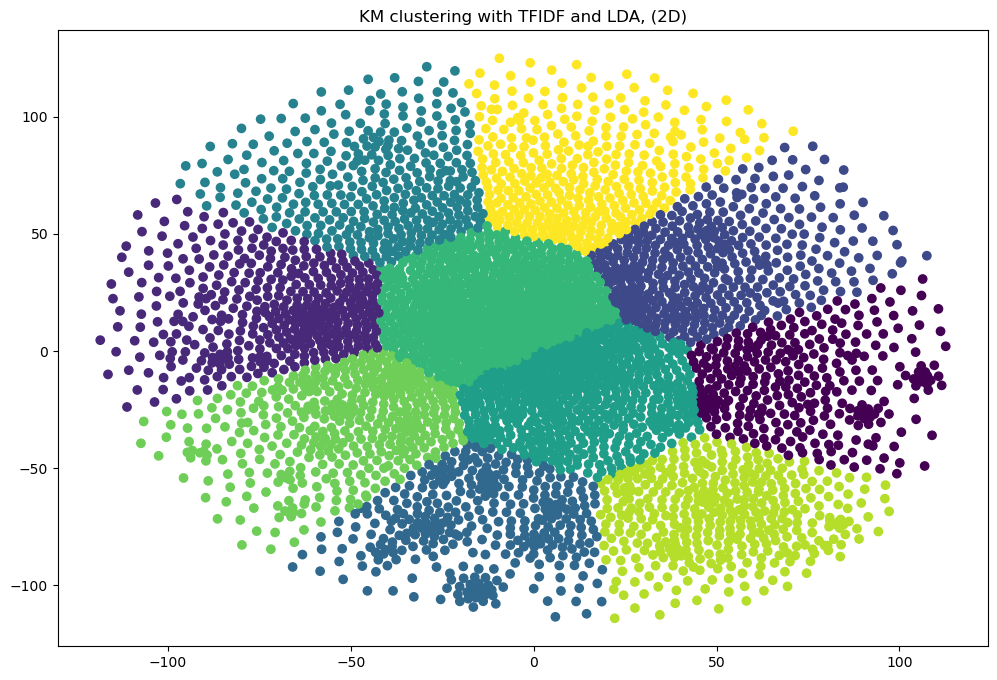

(array([[-89.86101 ,  17.32256 ],
        [  9.910993,  40.507973],
        [ 65.514565,  74.52801 ],
        ...,
        [-14.343646, 104.62647 ],
        [ 16.18672 , 108.31871 ],
        [ 46.101974,  -9.894692]], dtype=float32),
 array([1, 6, 2, ..., 9, 9, 0]))

In [6]:
clustering.cluster_and_plot(algorithm='LDA', clustering='KM', use_topic_modelling=False, use_tsne=True)